In [1]:
setwd('/import/DB/fel/BJTC-204')
library(cellcall)
scRNA = readRDS('male.sc.rds')
library(Seurat)



Registered S3 methods overwritten by 'treeio':
  method              from    
  MRCA.phylo          tidytree
  MRCA.treedata       tidytree
  Nnode.treedata      tidytree
  Ntip.treedata       tidytree
  ancestor.phylo      tidytree
  ancestor.treedata   tidytree
  child.phylo         tidytree
  child.treedata      tidytree
  full_join.phylo     tidytree
  full_join.treedata  tidytree
  groupClade.phylo    tidytree
  groupClade.treedata tidytree
  groupOTU.phylo      tidytree
  groupOTU.treedata   tidytree
  is.rooted.treedata  tidytree
  nodeid.phylo        tidytree
  nodeid.treedata     tidytree
  nodelab.phylo       tidytree
  nodelab.treedata    tidytree
  offspring.phylo     tidytree
  offspring.treedata  tidytree
  parent.phylo        tidytree
  parent.treedata     tidytree
  root.treedata       tidytree
  rootnode.phylo      tidytree
  sibling.phylo       tidytree

Warning message:
"package 'Seurat' was built under R version 4.2.3"
The legacy packages maptools, rgdal, and rgeo

In [3]:
table(scRNA$Condition)


   Case Control 
  42914   35065 

In [4]:
options(future.globals.maxSize= 1000*1024^2)

In [5]:
library(Seurat)

In [7]:
library(CellChat)
library(patchwork)

In [8]:
DefaultAssay(scRNA) = 'RNA'

In [9]:
scRNA$group = scRNA$Condition

In [10]:
Idents(scRNA) = 'group'

In [11]:
table(scRNA$group)


   Case Control 
  42914   35065 

In [23]:
scRNA$celltype = factor(scRNA$celltype,levels = c('InN','ExN','End','OPC','Ast','Oli','Mic'))

In [24]:
Idents(scRNA) = 'group'
wt = subset(scRNA,idents = 'Control')
ko = subset(scRNA,idents = 'Case')

In [25]:
cellchat <- createCellChat(object = wt,
                           meta = wt@meta.data,
                           group.by = "celltype")
cellchat

CellChatDB <- CellChatDB.human 
CellChatDB.use <- subsetDB(CellChatDB, search = "Secreted Signaling") 
# set the used database in the object
cellchat@DB <- CellChatDB.use

library(future)
cellchat <- subsetData(cellchat) 
# do parallel ，根据配置设置
plan(multisession, workers=40)
cellchat <- identifyOverExpressedGenes(cellchat)
#识别过表达配体受体对
cellchat <- identifyOverExpressedInteractions(cellchat)

[1] "Create a CellChat object from a Seurat object"
The `data` slot in the default assay is used. The default assay is RNA 


Warning message in createCellChat(object = wt, meta = wt@meta.data, group.by = "celltype"):
"The 'meta' data does not have a column named `samples`. We now add this column and all cells are assumed to belong to `sample1`! 
"


Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  InN, ExN, End, OPC, Ast, Oli, Mic 


An object of class CellChat created from a single dataset 
 33562 genes.
 35065 cells. 
CellChat analysis of single cell RNA-seq data! 

The number of highly variable ligand-receptor pairs used for signaling inference is 913 


In [26]:
cellchat <- smoothData(cellchat, adj = PPI.human)

In [27]:
unique(cellchat@idents)

[1] InN ExN End OPC Ast Oli Mic
Levels: InN ExN End OPC Ast Oli Mic

In [28]:
#project gene expression data onto PPI (Optional: when running it, USER should set `raw.use = FALSE` in the function `computeCommunProb()` in order to use the projected data)
library(future)
options(future.globals.maxSize= 400000000000000)
cellchat <- computeCommunProb(cellchat, raw.use = TRUE, population.size = TRUE) 

triMean is used for calculating the average gene expression per cell group. 
[1] ">>> Run CellChat on sc/snRNA-seq data <<< [2024-09-05 05:05:54]"
[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2024-09-05 05:09:04]"


In [29]:
# Filter out the cell-cell communication if there are only few number of cells in certain cell groups
cellchat <- filterCommunication(cellchat, min.cells = 5)
df.net <- subsetCommunication(cellchat)

In [30]:
cellchat <- aggregateNet(cellchat)
#计算每种细胞各有多少个
groupSize <- as.numeric(table(cellchat@idents))

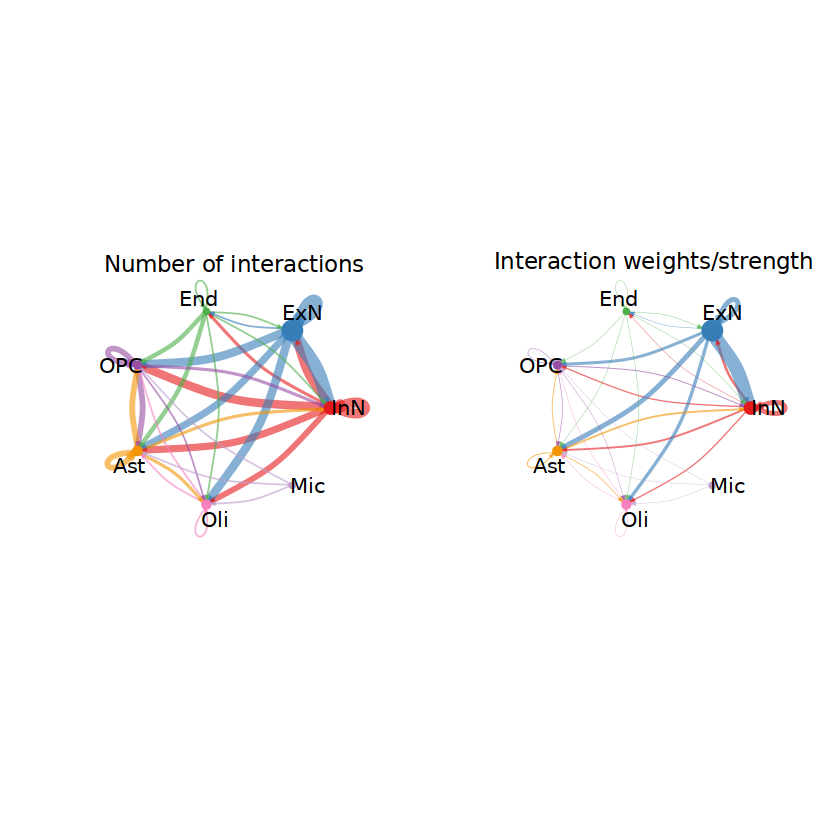

In [31]:

par(mfrow = c(1,2), xpd=TRUE)
p1 = netVisual_circle(cellchat@net$count, vertex.weight = groupSize, weight.scale = T, 
                     label.edge= F, title.name = "Number of interactions")
p2 = netVisual_circle(cellchat@net$weight, vertex.weight = groupSize, weight.scale = T, 
                     label.edge= F, title.name = "Interaction weights/strength")

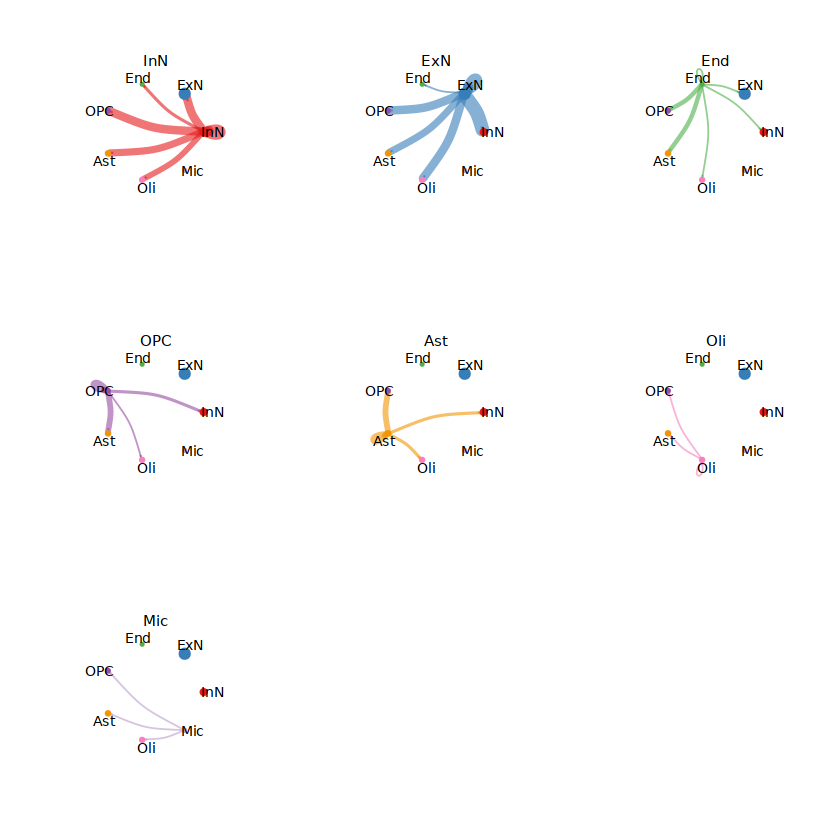

In [32]:
mat <- cellchat@net$count
par(mfrow = c(3,3), xpd=TRUE)
for (i in 1:nrow(mat)) {
  # i = 1
  mat2 <- matrix(0, nrow = nrow(mat), ncol = ncol(mat), dimnames = dimnames(mat))
  mat2[i, ] <- mat[i, ]
  netVisual_circle(mat2, vertex.weight = groupSize, weight.scale = T, arrow.width = 0.2,
                    arrow.size = 0.1, edge.weight.max = max(mat), title.name = rownames(mat)[i])
}
# save as TIL/net_number_individual.pdf

## 运行上述代码出现报错 Error in plot.new() : figure margins too large
# par("mar")
## [1] 5.1 4.1 4.1 2.1
# par(mar=c(1,1,1,1))
# 重新运行上面的代码

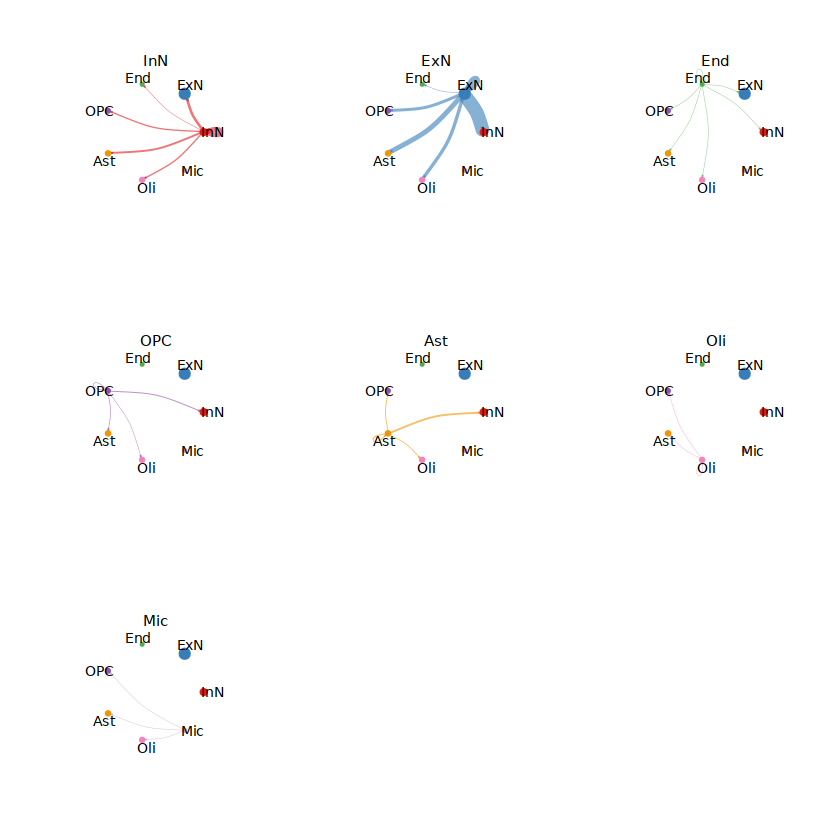

In [34]:
mat <- cellchat@net$weight
par(mfrow = c(3,3), xpd=T)
for (i in 1:nrow(mat)) {
  mat2 <- matrix(0, nrow = nrow(mat), ncol = ncol(mat), dimnames = dimnames(mat))
  mat2[i, ] <- mat[i, ]
  netVisual_circle(mat2, vertex.weight = groupSize, weight.scale = T, arrow.width = 0.2,
                   arrow.size = 0.1, edge.weight.max = max(mat), title.name = rownames(mat)[i])
}
# save as TIL/net_strength_individual.pdf

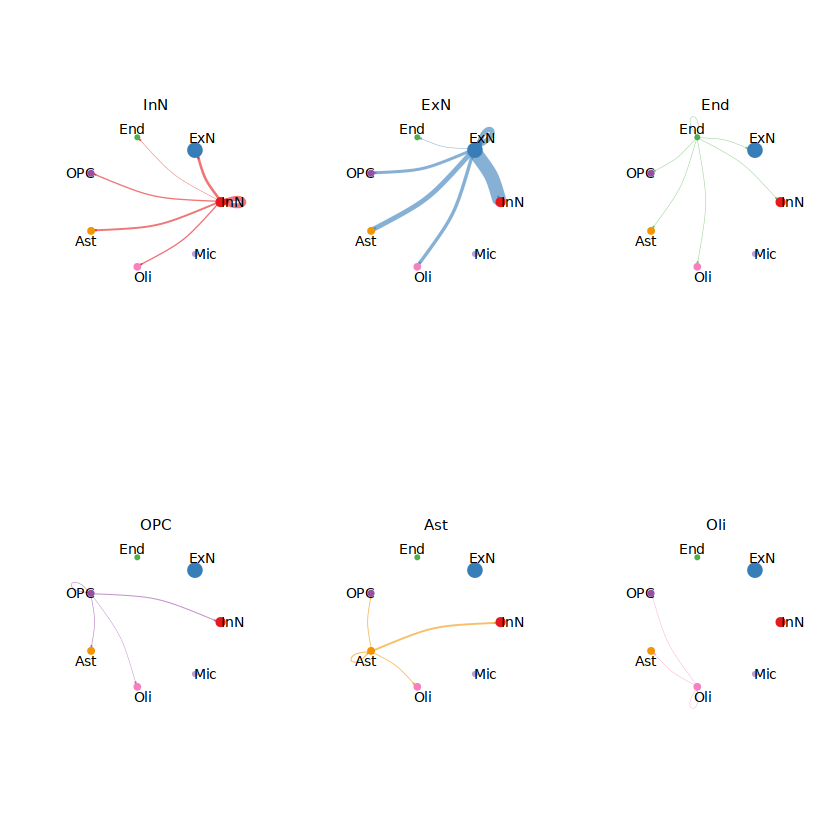

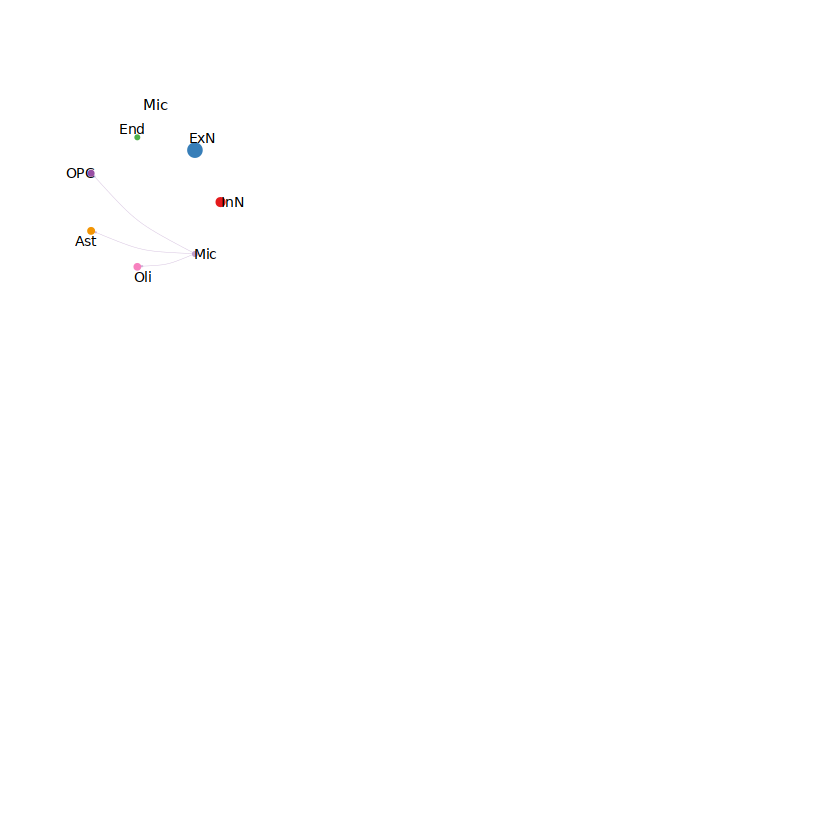

In [35]:
mat <- cellchat@net$weight
par(mfrow = c(2,3), xpd=T)
for (i in 1:nrow(mat)) {
      mat2 <- matrix(0, nrow = nrow(mat), ncol = ncol(mat), dimnames = dimnames(mat))
      mat2[i, ] <- mat[i, ]
      netVisual_circle(mat2, vertex.weight = groupSize, weight.scale = T, arrow.width = 0.2,
                       arrow.size = 0.1, edge.weight.max = max(mat), title.name = rownames(mat)[i])
    }
# save as TIL/net_strength_individual.pdf

In [36]:
cellchat <- computeCommunProbPathway(cellchat)
cellchat <- aggregateNet(cellchat)

In [37]:
cellchat@netP$pathways  #查看都有哪些信号通路
# [1] "TGFb"       "NRG"        "PDGF"       "CCL"        "CXCL"       "MIF"        "IL2"        "IL6"       
# [9] "IL10"       "IL1"        "CSF"        "IL16"       "IFN-II"     "LT"         "LIGHT"      "FASLG"     
# [17] "TRAIL"      "BAFF"       "CD40"       "VISFATIN"   "COMPLEMENT" "PARs"       "FLT3"       "ANNEXIN"   
# [25] "GAS"        "GRN"        "GALECTIN"   "BTLA"       "BAG"     
# 选择其中一个信号通路，比如说TGFb


[1] "NRG"    "SLIT"   "PTPR"   "SLITRK" "PSAP"   "CypA"   "PTN"    "IGF"

In [38]:
pathways.show <- cellchat@netP$pathways

[1] "InN" "ExN" "End" "OPC" "Ast" "Oli" "Mic"

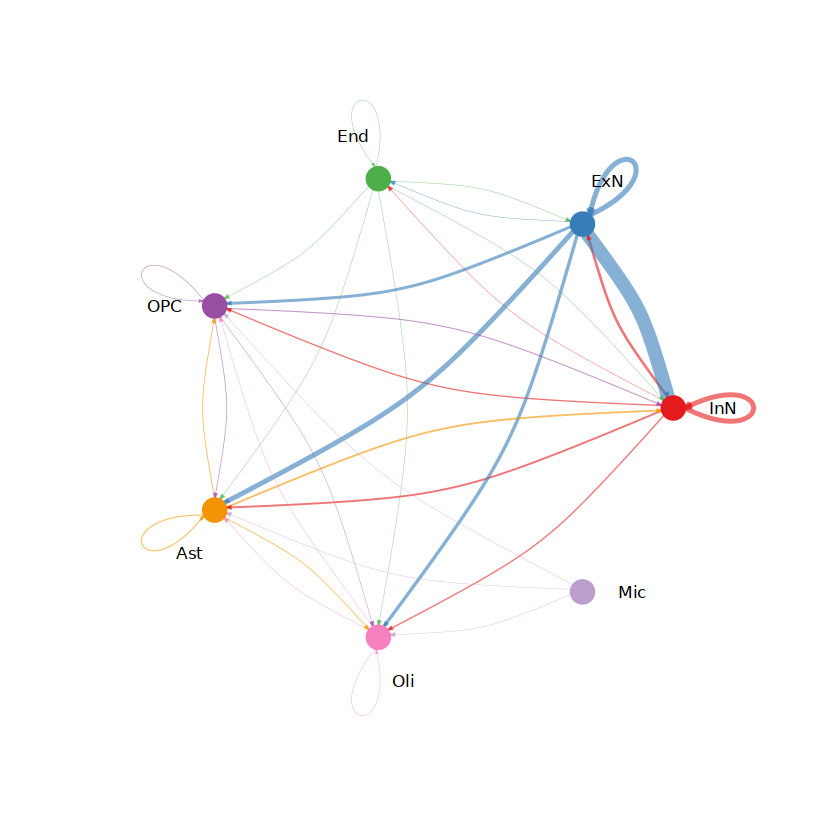

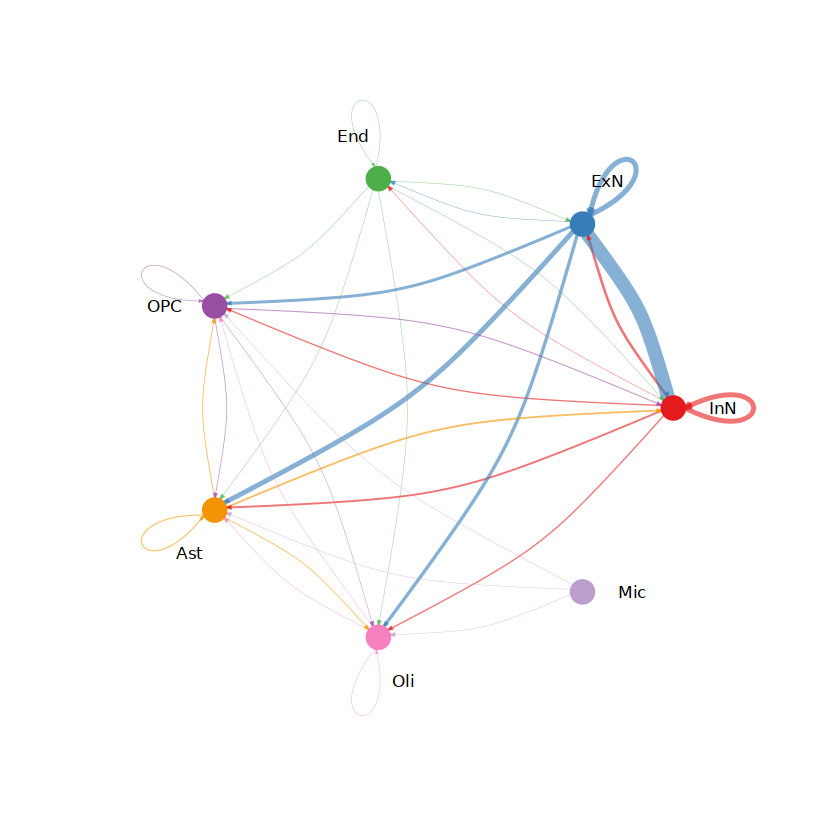

In [39]:
levels(cellchat@idents)    # show all celltype
# [1] "Naive CD4 T"  "Memory CD4 T" "CD14+ Mono"   "B"            "CD8 T"       
# [6] "FCGR3A+ Mono" "NK"           "DC"           "Platelet"    
vertex.receiver = c(1,2,4,6) # define a numeric vector （淋系细胞）giving the index of the celltype as targets
#par(mar=c(5.1,4.1,4.1,2.1))
netVisual_aggregate(cellchat, signaling = pathways.show,  vertex.receiver = vertex.receiver)
# save as TIL/CXCL_hierarchy.pdf

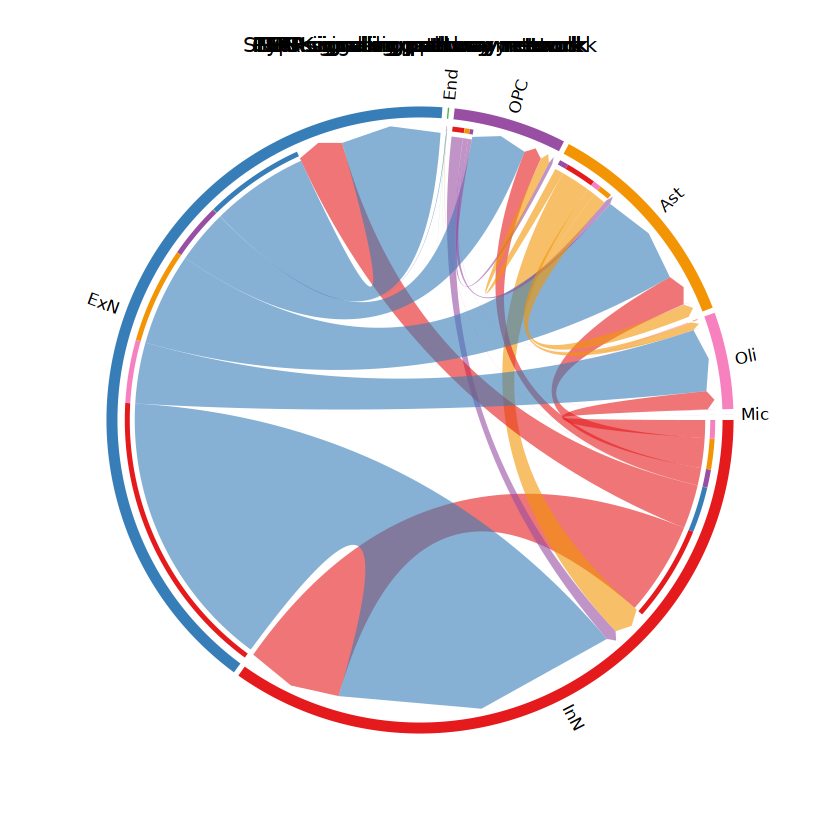

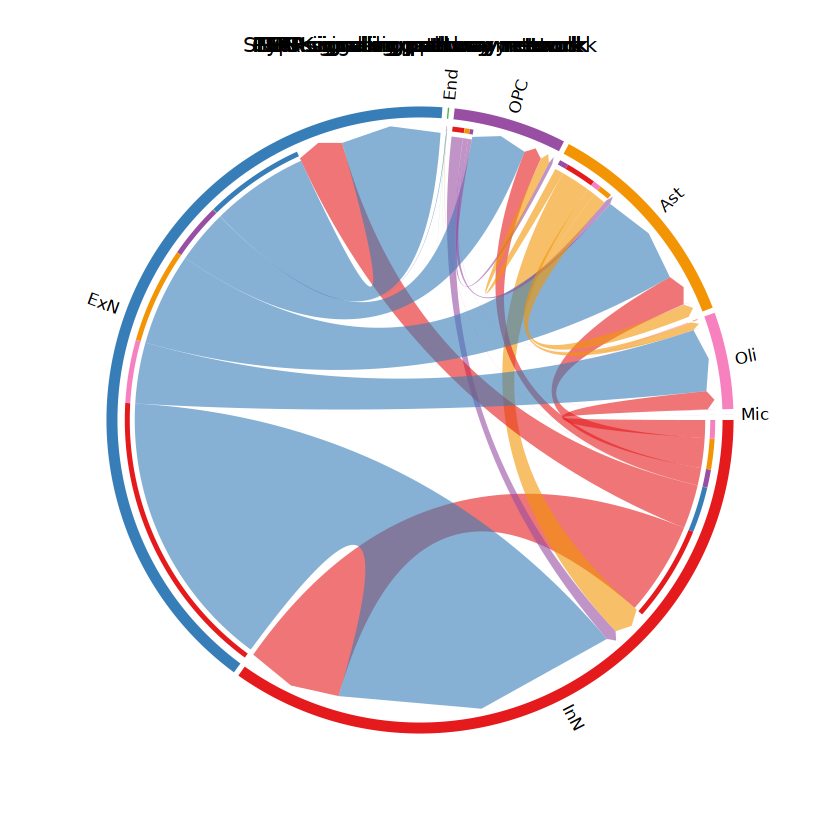

In [40]:
par(mfrow=c(1,1))
netVisual_aggregate(cellchat, signaling = pathways.show, layout = "chord")
# save as TIL/CXCL_chord.pdf

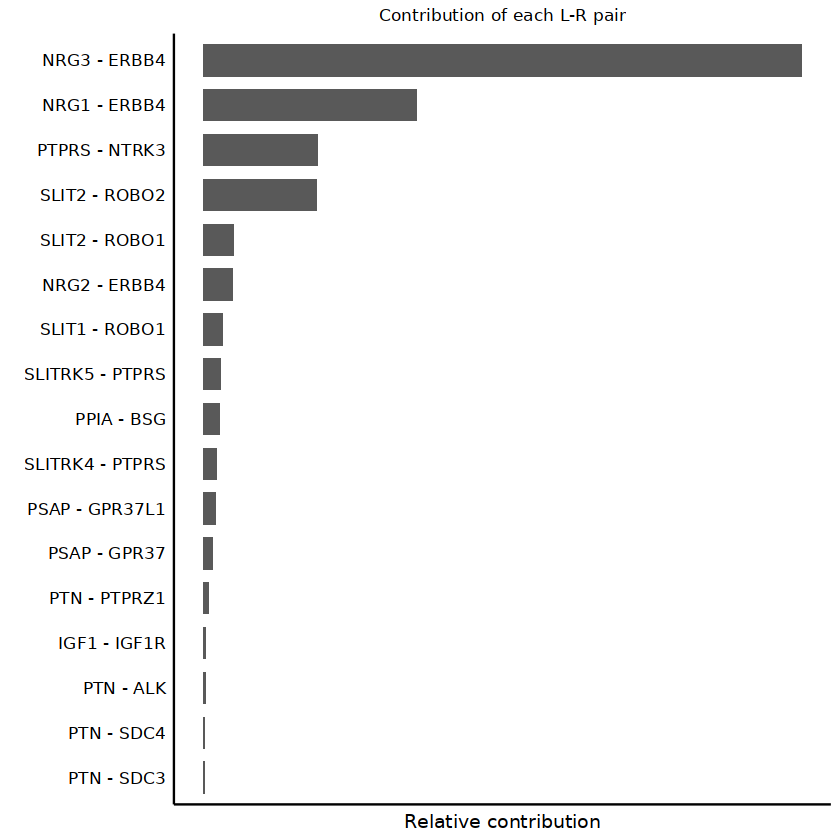

In [41]:
#计算配体受体对选定信号通路的贡献值（在这里就是查看哪条信号通路对TGFb贡献最大）
netAnalysis_contribution(cellchat, signaling = pathways.show)
pairLR.TGFb <- extractEnrichedLR(cellchat, signaling = pathways.show, geneLR.return = FALSE) #提取对TGFb有贡献的所有配体受体 
# save as TIL/CXCL_LR_contribution.pdf

[[1]]


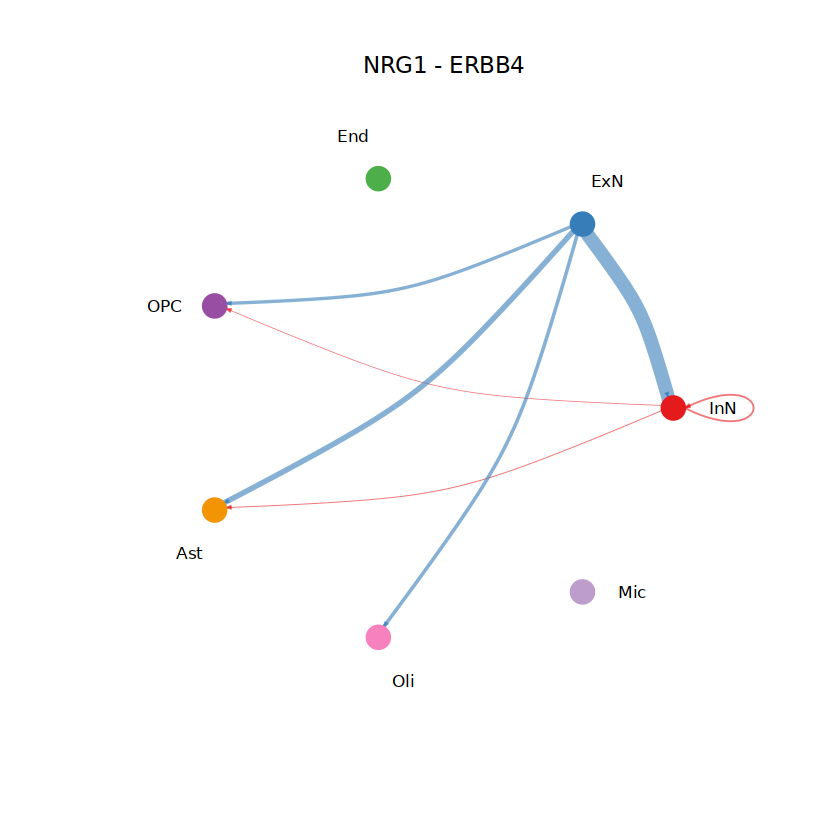

In [42]:
#提取对这个通路贡献最大的配体受体对来展示（也可以选择其他的配体受体对）
LR.show <- pairLR.TGFb[1,] 
vertex.receiver = c(1,2,4,6) # a numeric vector
netVisual_individual(cellchat, signaling = pathways.show,  pairLR.use = LR.show, vertex.receiver = vertex.receiver)
# save as TIL/CXCL_hierarchy2.pdf

In [43]:
levels(cellchat@idents)
# show all the significant interactions (L-R pairs)
#需要指定受体细胞和配体细胞
p = netVisual_bubble(cellchat, sources.use = c(3,5,7,8,9), 
                     targets.use = c(1,2,4,6), remove.isolate = FALSE)
#ggsave("Mye_Lymph_bubble.pdf", p, width = 8, height = 12) #髓系对淋巴的调节
# save as TIL/Mye_Lymph_bubble.pdf

[1] "InN" "ExN" "End" "OPC" "Ast" "Oli" "Mic"

Comparing communications on a single object 




In [44]:
cellchat <- computeCommunProbPathway(cellchat)
cellchat <- netAnalysis_computeCentrality(cellchat, slot.name = "netP")

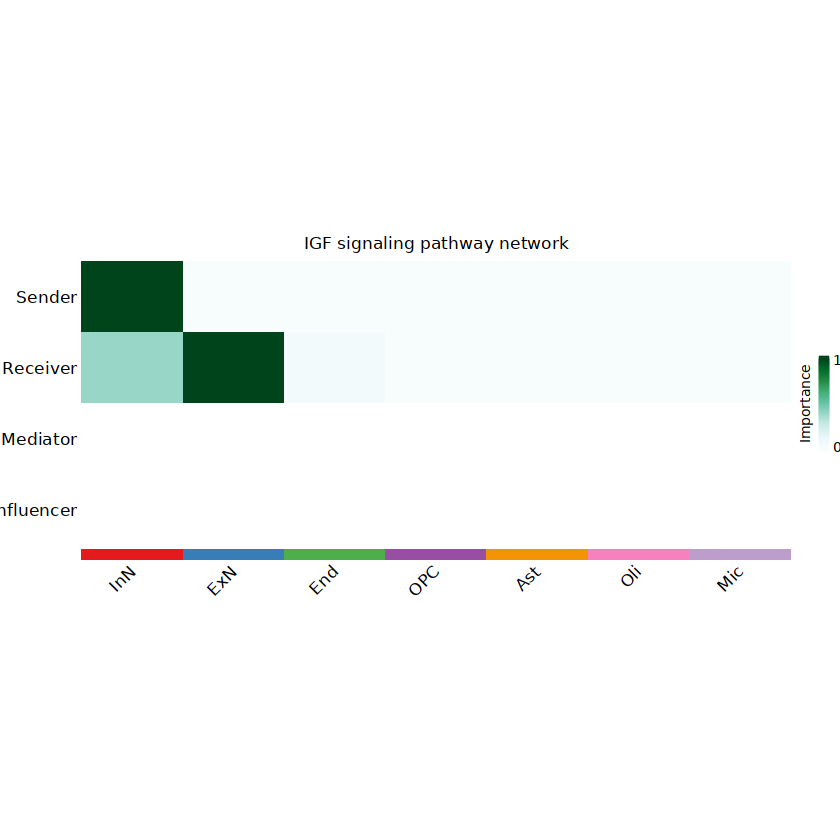

In [45]:
netAnalysis_signalingRole_network(cellchat, signaling = pathways.show, 
                                   width = 15, height = 6, font.size = 10)
# # save as TIL/SNA_CXCL_signalingRole.pdf

In [46]:
write.csv(df.net, "cell-cell_communications.all.wt.remove.dc.csv")
saveRDS(cellchat,file =  'wt.cellchat.removedc.rds')

In [47]:
wt

An object of class Seurat 
33562 features across 35065 samples within 1 assay 
Active assay: RNA (33562 features, 0 variable features)
 1 dimensional reduction calculated: umap

In [48]:
ko

An object of class Seurat 
33562 features across 42914 samples within 1 assay 
Active assay: RNA (33562 features, 0 variable features)
 1 dimensional reduction calculated: umap

In [49]:
cellchat <- createCellChat(object = ko,
                           meta = ko@meta.data,
                           group.by = "celltype")
cellchat

CellChatDB <- CellChatDB.human
CellChatDB.use <- subsetDB(CellChatDB, search = "Secreted Signaling") 
# set the used database in the object
cellchat@DB <- CellChatDB.use

library(future)
cellchat <- subsetData(cellchat) 
# do parallel ，根据配置设置
plan(multisession, workers=15)
cellchat <- identifyOverExpressedGenes(cellchat)
#识别过表达配体受体对
cellchat <- identifyOverExpressedInteractions(cellchat)

[1] "Create a CellChat object from a Seurat object"
The `data` slot in the default assay is used. The default assay is RNA 
Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  InN, ExN, End, OPC, Ast, Oli, Mic 


An object of class CellChat created from a single dataset 
 33562 genes.
 42914 cells. 
CellChat analysis of single cell RNA-seq data! 

The number of highly variable ligand-receptor pairs used for signaling inference is 914 


In [50]:
#project gene expression data onto PPI (Optional: when running it, USER should set `raw.use = FALSE` in the function `computeCommunProb()` in order to use the projected data)
cellchat <- smoothData(cellchat, adj = PPI.human)
library(future)
options(future.globals.maxSize= 4000000000000000)
cellchat <- computeCommunProb(cellchat, raw.use = TRUE, population.size = TRUE) 
# Filter out the cell-cell communication if there are only few number of cells in certain cell groups
cellchat <- filterCommunication(cellchat, min.cells = 5)
df.net <- subsetCommunication(cellchat)

triMean is used for calculating the average gene expression per cell group. 
[1] ">>> Run CellChat on sc/snRNA-seq data <<< [2024-09-05 06:18:18]"
[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2024-09-05 06:20:01]"


In [51]:
cellchat <- aggregateNet(cellchat)

In [52]:
cellchat <- computeCommunProbPathway(cellchat)
cellchat <- aggregateNet(cellchat)

cellchat@netP$pathways#查看都有哪些信号通路
# [1] "TGFb"       "NRG"        "PDGF"       "CCL"        "CXCL"       "MIF"        "IL2"        "IL6"       
# [9] "IL10"       "IL1"        "CSF"        "IL16"       "IFN-II"     "LT"         "LIGHT"      "FASLG"     
# [17] "TRAIL"      "BAFF"       "CD40"       "VISFATIN"   "COMPLEMENT" "PARs"       "FLT3"       "ANNEXIN"   
# [25] "GAS"        "GRN"        "GALECTIN"   "BTLA"       "BAG"     
# 选择其中一个信号通路，比如说TGFb
pathways.show <- cellchat@netP$pathways 

[1] "NRG"    "SLIT"   "PTPR"   "SLITRK" "CypA"   "IGF"    "PSAP"   "PTN"

In [53]:
write.csv(df.net, "cell-cell_communications.all.ko.removedc.csv")
saveRDS(cellchat,file =  'ko.cellchat.removedc.rds')